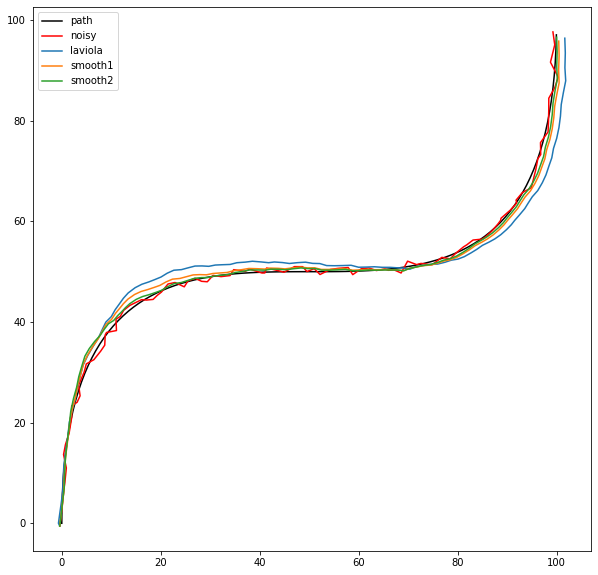

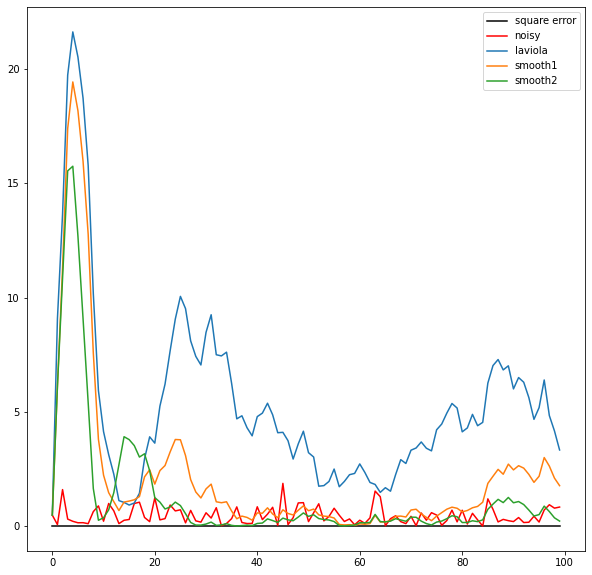

AVG SQUARE ERROR
NOISE: 0.4676787325474314
LAVIOLA: 5.333675589986711
SMOOTH1: 2.190435062611513
SMOOTH2: 1.3302100402009032

AVG SQUARE ERROR AFTER STABLE
NOISE: 0.4688172959974739
LAVIOLA: 4.418140583217532
SMOOTH1: 1.1779117865538153
SMOOTH2: 0.6132637542536914


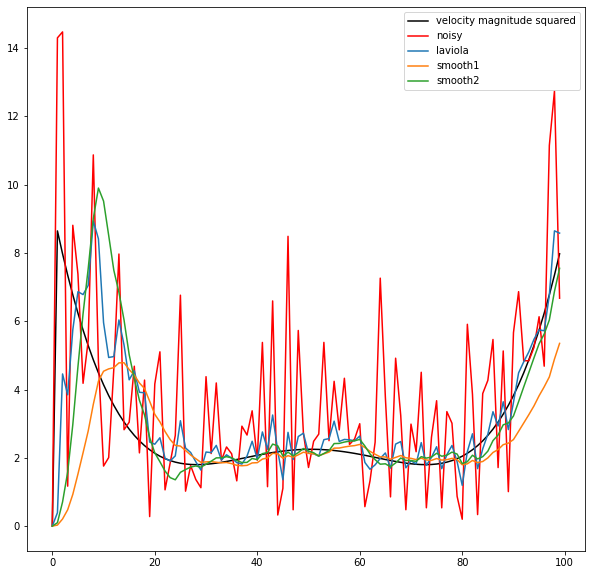

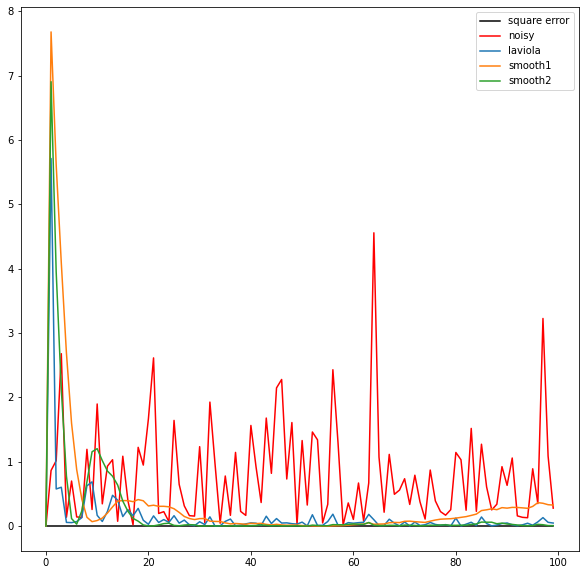

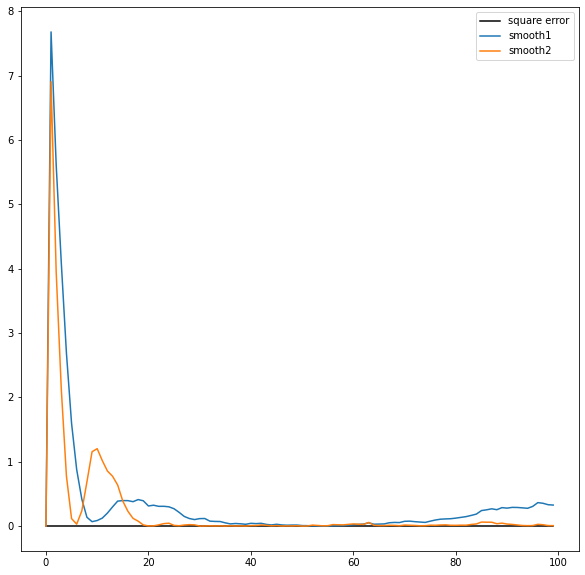

AVG SQUARE ERROR
NOISE: 0.7990665431596795
LAVIOLA: 0.1500622335059216
SMOOTH1: 0.3601452992772115
SMOOTH2: 0.22571195653721218


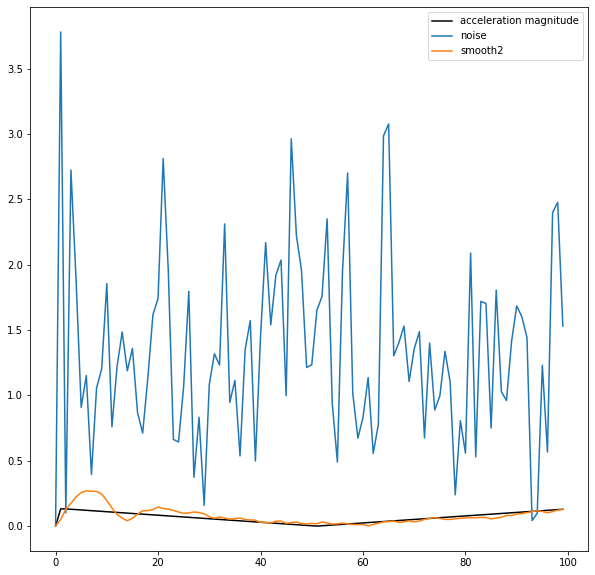

In [94]:
from typing import List
from shared import Vec2
import matplotlib.pyplot as plt
import numpy as np


def bezier(start: Vec2, end: Vec2, c1: Vec2, c2: Vec2, samples: int) -> List[Vec2]:
    points: List[Vec2] = []
    for i in range(samples):
        t = i / samples
        s = 1.0 - t
        points.append(
            s ** 3 * start + 3 * s ** 2 * t * c1 + 3 * s * t ** 2 * c2 + t ** 3 * p2
        )
    return points


def draw_path(path: List[Vec2], style: str = "ko-", label: str = None, *, plot=None):
    _path = np.array(path)
    xpath = _path[:, 0]
    ypath = _path[:, 1]

    if plot is None:
        fig = plt.figure(figsize=(10, 10))
        plot = fig.add_subplot()
    plot.plot(xpath, ypath, style, label=label)
    return plot

def draw_line(path: List[float], style: str = "ko-", label: str = None, *, plot=None):
    xpath = np.array(path)

    if plot is None:
        fig = plt.figure(figsize=(10, 10))
        plot = fig.add_subplot()
    plot.plot(xpath, style, label=label)
    return plot


def velocity(path: List[Vec2]):
    v = [Vec2(0, 0)]
    for i in range(len(path) - 1):
        v.append(path[i + 1] - path[i])
    return v


def noisy(path: List[Vec2], scale: float = 1):
    noise = np.random.normal(loc=0, scale=scale, size=(len(path), 2))
    return [(p + n).view(Vec2) for p, n in zip(path, noise)]


def laviola(path: List[Vec2], k: float = 0.85, out=''):
    p = [path[0]] + [None] * (len(path) - 1)
    v = [Vec2(0, 0)] + [None] * (len(path) - 1)
    _out = [path[0]] + [None] * (len(path) - 1)

    for i in range(1, len(path)):
        observed = path[i]

        p[i] = k * p[i - 1] + (1 - k) * observed
        v[i] = k * v[i - 1] + (1 - k) * p[i]
        _out[i] = (2 + (1 - k) / k) * p[i] - (1 + (1 - k) / k) * v[i]
    
    if out == 'v':
        return v

    return _out


def smooth1(path: List[Vec2], k: float = 0.85, out=''):
    k_correction = k / (1 - k)

    p = [path[0]] + [None] * (len(path) - 1)
    v = [Vec2(0, 0)] + [None] * (len(path) - 1)
    _out = [path[0]] + [None] * (len(path) - 1)

    for i in range(1, len(path)):
        observed = path[i]

        predicted = p[i - 1] + v[i - 1]
        p[i] = k * predicted + (1 - k) * observed
        v[i] = k * v[i - 1] + (1 - k) * (p[i] - predicted)
        _out[i] = p[i] + v[i] * k_correction

    if out=='v':
        return [v_ * 2 for v_ in v]
        return v

    return _out


def smooth2(path: List[Vec2], k: float = 0.85, out=''):
    k_correction = k / (1 - k)

    p = [path[0]] + [None] * (len(path) - 1)
    v = [Vec2(0, 0)] + [None] * (len(path) - 1)
    a = [Vec2(0, 0)] + [None] * (len(path) - 1)
    _out = [path[0]] + [None] * (len(path) - 1)

    for i in range(1, len(path)):
        observed = path[i]

        p_pred = p[i - 1] + v[i - 1] + a[i - 1] * 0.5
        p[i] = k * p_pred + (1 - k) * observed
        v_pred = v[i - 1] + a[i - 1]
        v[i] = k * v_pred + (1 - k) * (p[i] - p_pred)
        a[i] = k * a[i - 1] + (1 - k) * (v[i] - v_pred)
        _out[i] = p[i] + v[i] * k_correction
        
    if out == 'a':
        return [a_ * 4 for a_ in a]

    if out == 'v':
        return [(v_ + a_ * k_correction) * 2 for v_, a_ in zip(v, a)]

    # if out == 'v':
    #     return [v_ * 2 for v_, a_ in zip(v, a)]
    # if out == 'v1':
    #     return [(v_ * 2 + a_ * k_correction)  for v_, a_ in zip(v, a)]
    # if out == 'v2':
    #     return [(v_ + a_ * k_correction) * 2 for v_, a_ in zip(v, a)]

    return _out


def kalman(path: List[Vec2]):
    pass

def __sq_mag(v: Vec2):
    return v.dot(v)

sq_mag = np.vectorize(__sq_mag, signature='(v)->()')

p1 = Vec2(0, 0)
p2 = Vec2(100, 100)
c1 = Vec2(0, 100)
c2 = Vec2(100, 0)

path = bezier(p1, p2, c1, c2, 100)
fig_path = draw_path(path, "k-", "path")

noise = noisy(path, 1)
draw_path(noise, "r-", "noisy", plot=fig_path)

viola = laviola(noise)
draw_path(viola, "", "laviola", plot=fig_path)

sm1 = smooth1(noise)
draw_path(sm1, "", "smooth1", plot=fig_path)

sm2 = smooth2(noise)
draw_path(sm2, "", "smooth2", plot=fig_path)

plt.legend()
plt.show()


err_path = [sq_mag(p - n) for p, n in zip(path, path)]
fig_noise = draw_line(err_path, "k-", "square error")

err_noise = [sq_mag(p - n) for p, n in zip(path, noise)]
draw_line(err_noise, "r-", "noisy", plot=fig_noise)

err_viola = [sq_mag(p - n) for p, n in zip(path, viola)]
draw_line(err_viola, "", "laviola", plot=fig_noise)

err_sm1 = [sq_mag(p - n) for p, n in zip(path, sm1)]
draw_line(err_sm1, "", "smooth1", plot=fig_noise)

err_sm2 = [sq_mag(p - n) for p, n in zip(path, sm2)]
draw_line(err_sm2, "", "smooth2", plot=fig_noise)

plt.legend()
plt.show()

print(f'AVG SQUARE ERROR')
print(f'NOISE: {np.mean(err_noise)}')
print(f'LAVIOLA: {np.mean(err_viola)}')
print(f'SMOOTH1: {np.mean(err_sm1)}')
print(f'SMOOTH2: {np.mean(err_sm2)}')
print()
print(f'AVG SQUARE ERROR AFTER STABLE')
print(f'NOISE: {np.mean(err_noise[10:])}')
print(f'LAVIOLA: {np.mean(err_viola[10:])}')
print(f'SMOOTH1: {np.mean(err_sm1[10:])}')
print(f'SMOOTH2: {np.mean(err_sm2[10:])}')


vel = velocity(path)
# fig_vel = draw_path(vel, "k-", "velocity")
fig_vel = draw_line(sq_mag(vel), "k-", "velocity magnitude squared")

v_noise = velocity(noise)
# draw_path(v_noise, "r-", "noisy", plot=fig_vel)
draw_line(sq_mag(v_noise), "r-", "noisy", plot=fig_vel)

v_viola = velocity(viola)
# draw_path(v_viola, "", "laviola", plot=fig_vel)
draw_line(sq_mag(v_viola), "", "laviola", plot=fig_vel)

v_sm1 = smooth1(noise, out='v')
# draw_path(v_sm1, "", "smooth1", plot=fig_vel)
draw_line(sq_mag(v_sm1), "", "smooth1", plot=fig_vel)

v_sm2 = smooth2(noise, out='v')
# draw_path(v_sm2, "", "smooth2", plot=fig_vel)
draw_line(sq_mag(v_sm2), "", "smooth2", plot=fig_vel)

plt.legend()
plt.show()

err_path = [sq_mag(p - n) for p, n in zip(vel, vel)]
fig_noise = draw_line(err_path, "k-", "square error")

err_noise = [sq_mag(p - n) for p, n in zip(vel, v_noise)]
draw_line(err_noise, "r-", "noisy", plot=fig_noise)

err_viola = [sq_mag(p - n) for p, n in zip(vel, v_viola)]
draw_line(err_viola, "", "laviola", plot=fig_noise)

err_sm1 = [sq_mag(p - n) for p, n in zip(vel, v_sm1)]
draw_line(err_sm1, "", "smooth1", plot=fig_noise)

err_sm2 = [sq_mag(p - n) for p, n in zip(vel, v_sm2)]
draw_line(err_sm2, "", "smooth2", plot=fig_noise)

plt.legend()
plt.show()

fig_noise = draw_line(err_path, "k-", "square error")
draw_line(err_sm1, "", "smooth1", plot=fig_noise)
draw_line(err_sm2, "", "smooth2", plot=fig_noise)

plt.legend()
plt.show()

print(f'AVG SQUARE ERROR')
print(f'NOISE: {np.mean(err_noise)}')
print(f'LAVIOLA: {np.mean(err_viola)}')
print(f'SMOOTH1: {np.mean(err_sm1)}')
print(f'SMOOTH2: {np.mean(err_sm2)}')

# vel = velocity(path)
# fig_vel = draw_path(vel, "k-", "velocity")

# noise = path
# sm90 = smooth2(noise, out='v')
# draw_path(sm90, "", "90", plot=fig_vel)

# sm91 = smooth2(noise, out='v1')
# draw_path(sm91, "", "91", plot=fig_vel)

# sm92 = smooth2(noise, out='v2')
# draw_path(sm92, "", "92", plot=fig_vel)

# plt.legend()
# plt.show()

# print(f'AVG SQUARE ERROR')
# print(f'90: {np.mean([sq_mag(v - s) for v, s in zip(vel, sm90)])}')
# print(f'91: {np.mean([sq_mag(v - s) for v, s in zip(vel, sm91)])}')
# print(f'92: {np.mean([sq_mag(v - s) for v, s in zip(vel, sm92)])}')

vel = velocity(velocity(path))
vel[1] = vel[2]
# fig_vel = draw_path(vel, "k-", "velocity")
fig_vel = draw_line(np.sqrt(sq_mag(vel)), "k-", "acceleration magnitude")

a_noise = velocity(velocity(noise))
# draw_path(a_noise, "", "noise", plot=fig_vel)
draw_line(np.sqrt(sq_mag(a_noise)), "", "noise", plot=fig_vel)

v_sm2 = smooth2(noise, out='a')
# draw_path(v_sm2, "", "smooth2", plot=fig_vel)
draw_line(np.sqrt(sq_mag(v_sm2)), "", "smooth2", plot=fig_vel)

plt.legend()
plt.show()